### Naive Bayes Classifier sentiment analysis with scikit-learn

In this notebook, a Naive Bayes Classifier is used to classify french and german tweets. In the provided data, a sentiment analysis has already been done on the french and german tweets, but only using the smileys. Now, the classified tweets are used to classify the other tweets that do not have these smileys and that have been classified as neutral. One problem is that we do not have tweets that have been classified as neural BECAUSE they are neutral. Indeed, most neutral tweets are in fact unclassified tweets. Because of class imbalances, we only consider subsets of positive tweets.

Import the libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import itertools
import matplotlib.pyplot as plt
from nltk.tokenize.casual import TweetTokenizer
from nltk.stem.snowball import FrenchStemmer, GermanStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn import preprocessing

Use the snowball algorithm (http://snowballstem.org/) to stem french and german words. A casual tokenizer is used as it is more adapted to Twitter data. Stopwords are also loaded for both languages. A simple regular expression is compiled to detect links.

In [2]:
fr_stemmer = FrenchStemmer()
de_stemmer = GermanStemmer()
tokenizer = TweetTokenizer(strip_handles=True)
stop = stopwords.words('french') + stopwords.words('german')
re_url = re.compile('^(http[s]?://)?[\S]+\.\S[\S]+[/?#][\S]+$')

Let's now define some useful function to make the code easier to read

Remove stopwords, URLs and single character words

In [3]:
def filter_word(word):
    return word not in stop and not re_url.match(word) and len(word) > 1

Stem th word after removing a possible hashsign

In [4]:
def clean_word(stemmer, word):
    return stemmer.stem(word.replace('#', ''))

Convert a list of lists of items to a list of items (2D -> 1D)

In [5]:
def flatten(lst):
    return [item for sublist in lst for item in sublist]

Transform a tweet into a list of cleaned, stemmed words

In [6]:
def process(x, stemmer):
    return ' '.join(clean_word(stemmer, word) for word in tokenizer.tokenize(x) if filter_word(word))

Parse one month of data from a CSV file for a given language. Tweets are separated by sentiment in three different Pandas DataFrames.

In [7]:
def parse_month(curr_pos, curr_neg, curr_neu, lang, month):
    raw = pd.read_csv('../processed/tweets_non-en_msg_{}.csv'.format(month), escapechar='\\')
    raw.columns=['source_location', 'lang', 'main', 'sentiment']

    filtered = raw[raw.lang == lang]

    pos = filtered[filtered.sentiment == 'POSITIVE']
    neg = filtered[filtered.sentiment == 'NEGATIVE']
    neu = filtered[filtered.sentiment == 'NEUTRAL']
    
    stemmer = fr_stemmer if lang == 'fr' else de_stemmer if lang == 'de' else None

    pos = pos[['source_location', 'sentiment']].assign(tokenized=pos['main'].apply(lambda x: process(x, stemmer)))
    neg = neg[['source_location', 'sentiment']].assign(tokenized=neg['main'].apply(lambda x: process(x, stemmer)))
    neu = neu[['source_location', 'sentiment']].assign(tokenized=neu['main'].apply(lambda x: process(x, stemmer)))
    
    if curr_pos is None:
        return (pos, neg, neu)
    else:
        return (pd.concat([curr_pos, pos], copy=False),
                pd.concat([curr_neg, neg], copy=False),
                pd.concat([curr_neu, neu], copy=False))

Take all the neutral tweets and give them the label POSITIVE or NEGATIVE. If a tweet does not contain words found in the training set, then give it the NEUTRAL label.

In [8]:
def classify_neutral_tweets(classifier, X_train, neutral):
    # We need to find what features were found in the tweet. Training this at each function call
    # is OVERKILL. But it doesn't slow the process that much -> to be improved in the future.
    count_vec = CountVectorizer()
    fit = count_vec.fit(X_train)
    features = count_vec.transform(neutral.tokenized.tolist())
    
    # Classify tweets
    predicted = classifier.predict(neutral.tokenized.tolist())
    neutral = neutral.assign(sentiment=predicted)
    
    # Remove unclassifiable tweets (their features is the zero matrix)
    stay_neutral = np.array(features.sum(axis=1) == 0).squeeze()
    neutral['sentiment'][stay_neutral] = 'NEUTRAL'
    
    return neutral

Classify the tweets for the given months. For the best resulsts, cross-validation and grid search are used. Grid search is done on the number of n-grams, the utilization of idf and the bayes smoothing paramters. See the comments in the following cell for details.

In [9]:
def sentiments_by_month(dataset, lang, months):
    X = dataset.tokenized.tolist()
    y = dataset.sentiment.tolist()

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    
    # Create a classifier pipeline
    clf = Pipeline([('count_vec', CountVectorizer()), ('tfidf', TfidfTransformer()), ('bayes', MultinomialNB())])
    
    # Set the grid search parameters
    parameters = {'count_vec__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
                  'tfidf__use_idf': (False, True),
                  'bayes__alpha': (1, 1e-1, 1e-2, 1e-3)}
    
    # Do grid search with 5-fold cross-validation
    clf_gs = GridSearchCV(clf, parameters, cv=5, n_jobs=3)
    clf_gs.fit(X_train, y_train)

    print("Accuracy: {}".format(round(clf_gs.best_score_, 3)))
    
    # Compute and plot the confusion matrix
    predicted = clf_gs.predict(X_test)
    labels = ['NEGATIVE', 'POSITIVE']
    matrix = metrics.confusion_matrix(y_test, predicted, labels=labels)
    
    print("Confusion matrix:")
    plt.figure()
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.xticks([0, 1], labels, rotation=45)
    plt.yticks([0, 1], labels)
    
    # Write the number of elements in each cell
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, matrix[i, j],
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")
    
    plt.show()

    # Compute output for all months
    output = {}
    
    for month in months:
        print("Classifying month {}...".format(month))
        positive, negative, neutral = parse_month(None, None, None, lang, month)
        
        # Predicted tweets are concatenated with already classified tweets
        output[month] = pd.concat([positive, negative, classify_neutral_tweets(clf_gs, X_train, neutral)])[['source_location', 'sentiment']]
        
    return output

Load the data from the CSVs. Store the tweets of different languages in different DataFrames. The `<lang>_all` DataFrames contains positive and negative tweets for a specific language. `<neu>_all` contain neutral tweets. Empty tweets (after processing) are removed from these DataFrames.

In [10]:
# Prepare variables to store the data for each language and sentiment
fr_pos = None
fr_neg = None
fr_neu = None
de_pos = None
de_neg = None
de_neu = None

# The months we have in the data
months = [
    'january',
    'february',
    'march',
    'april',
    'may',
    'june',
    'july',
    'august',
    'september',
    'october'
]

# fr
for month in months:
    fr_pos, fr_neg, fr_neu = parse_month(fr_pos, fr_neg, fr_neu, 'fr', month)

fr_pos = fr_pos[0:len(fr_neg)]                          # Undersample due to class imbalance
fr_all = pd.concat([fr_pos, fr_neg], copy=False)        # Build labeled set
fr_all = fr_all[fr_all.tokenized != '']                 # Remove empty strings
fr_neu = fr_neu[fr_neu.tokenized != '']

# de
for month in months:
    de_pos, de_neg, de_neu = parse_month(de_pos, de_neg, de_neu, 'de', month)

de_pos = de_pos[0:len(de_neg)]
de_all = pd.concat([de_pos, de_neg], copy=False)
de_all = de_all[de_all.tokenized != '']
de_neu = de_neu[de_neu.tokenized != '']

Let's take a look at the data that will be used to train the classifiers.

In [11]:
fr_all.head()

,source_location,sentiment,tokenized
4,Delémont,POSITIVE,arrêt foutr merd 2016 svp merc beaucoup bon nu...
414,Baden,POSITIVE,nous bier pros neujahr ;)
1366,Lausanne,POSITIVE,on calcul le gen réveillent mainten alor bon a...
1439,Lausanne,POSITIVE,ça manqu peut-êtr peu poes ça mani d'optimis p...
1467,Lausanne,POSITIVE,bon anné coral te compliqu trop vi ;)


In [12]:
de_all.head()

,source_location,sentiment,tokenized
41,Zuerich,POSITIVE,so start neu jahr :-)
50,Biel/Bienne,POSITIVE,ja chonnt mach ;)
134,Solothurn,POSITIVE,solang stolp fall fuhrt gewiss rein ;-)
180,Biel/Bienne,POSITIVE,wir hoff ihr hattet gut start neu jahr ;-) wir...
216,Chur,POSITIVE,es gab schnee jahr :)


We want to store the results per month. Classify the tweets and keep only source_location and sentiment, per month. We also plot the accuracy as well as the confusion matrix to estimate how well the classifiers perform

Accuracy: 0.76
Confusion matrix:


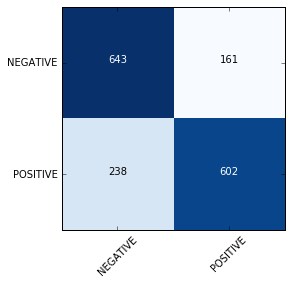

Classifying month january...
Classifying month february...
Classifying month march...
Classifying month april...
Classifying month may...
Classifying month june...
Classifying month july...
Classifying month august...
Classifying month september...
Classifying month october...


In [13]:
fr_by_month = sentiments_by_month(fr_all, 'fr', months)

Export the data to CSV that will be loaded on the map.

In [14]:
columns = ['source_location', 'sentiment']
path = '../processed/sentiments/tweets_sentiments_bayes_fr_{}.csv'

for key, df in fr_by_month.items():
    f = open(path.format(key), 'w')
    f.write(pd.DataFrame(df.groupby(columns).size()).to_csv())
    f.close()

Do the same for german tweets.

Accuracy: 0.708
Confusion matrix:


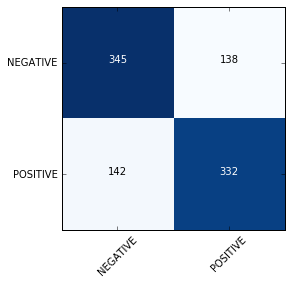

Classifying month january...
Classifying month february...
Classifying month march...
Classifying month april...
Classifying month may...
Classifying month june...
Classifying month july...
Classifying month august...
Classifying month september...
Classifying month october...


In [15]:
de_by_month = sentiments_by_month(de_all, 'de', months)

In [16]:
columns = ['source_location', 'sentiment']
path = '../processed/sentiments/tweets_sentiments_bayes_de_{}.csv'

for key, df in de_by_month.items():
    f = open(path.format(key), 'w')
    f.write(pd.DataFrame(df.groupby(columns).size()).to_csv())
    f.close()